<a href="https://colab.research.google.com/github/sanglic/idal_ia3_uv/blob/main/Ultimo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np
from glob import glob
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [ ]:
COLAB = True
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1cc5JyQvS4jJard7YsFKrYnHEcal0Bl6x',
                                        dest_path='./seg_train.zip', unzip=True)
    gdd.download_file_from_google_drive(file_id='1Gv5x1Y6K4JVLambfMBwGbDUDTC0xSQ2r',
                                        dest_path='./seg_test.zip', unzip=True)
    

In [ ]:
ficheros = glob("./seg_train/buildings/*")

In [ ]:
train_data_dir = 'seg_train'
validation_data_dir = 'seg_test'
test_data_dir = 'seg_test'

batch_size = 16

In [ ]:
img_width, img_height = 150, 150

normed_dims = (img_height, img_width)

In [ ]:
# data augmentation:

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen= ImageDataGenerator(rescale=1./255)

In [ ]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

In [ ]:
#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
for layer in model_vgg16_conv.layers:
			layer.trainable = False
model_vgg16_conv.summary()

In [ ]:
#Create your own input format (here 3x150x150)
Keras_input = Input(shape=(150,150,3),name = 'seg_train')

In [ ]:
#Use the generated model 
output_vgg16_conv = model_vgg16_conv(Keras_input)

In [ ]:
#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(6, activation='softmax', name='predictions')(x)

In [ ]:
#Create your own model 
my_model = Model(inputs=Keras_input, outputs=x)

In [ ]:
#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()

In [ ]:
my_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

In [ ]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

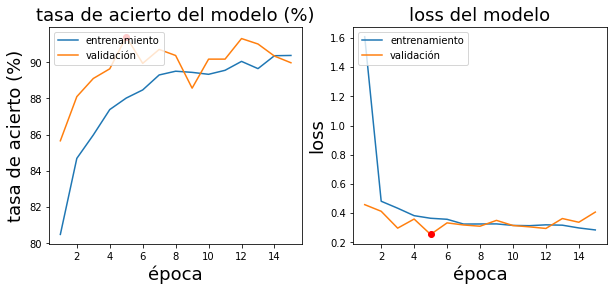

In [200]:
epochs = 1

modelpath="best_model.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                              save_best_only=True,
                              mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = my_model.fit_generator(generator = train_generator, 
                                  steps_per_epoch=number_train_samples // batch_size,
                                  epochs=1,
                                  callbacks=callbacks_list,
                                  verbose=1,
                                  shuffle = True,
                                  validation_data=validation_generator,
                                  validation_steps=number_val_samples // batch_size
                                  )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [201]:
model = load_model(modelpath)

In [202]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

878/878 [==============================] - 87s 99ms/step - loss: 0.3034 - accuracy: 0.9074
Train loss    : 0.30339717864990234
Train accuracy: 0.9073678255081177

188/188 [==============================] - 7s 37ms/step - loss: 0.4088 - accuracy: 0.8993
Val loss    : 0.40875229239463806
Val accuracy: 0.8993333578109741

188/188 [==============================] - 7s 37ms/step - loss: 0.4088 - accuracy: 0.8993
Test loss     : 0.40875229239463806
Test accuracy : 0.8993333578109741


In [203]:
y_real = test_generator.classes
y_pred_proba = model.predict_generator(test_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [204]:
y_real[:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [205]:
y_pred_proba[:5]

array([[1.0000000e+00, 2.0480168e-25, 1.4737550e-15, 1.1655213e-21,
        8.8834982e-17, 8.7489571e-10],
       [9.9810070e-01, 6.4327715e-10, 8.7408480e-06, 3.2442120e-08,
        2.6161219e-06, 1.8878640e-03],
       [1.0000000e+00, 3.4307177e-29, 3.8760728e-18, 1.4171123e-23,
        1.1328047e-19, 3.0973688e-10],
       [9.9999845e-01, 4.8954847e-21, 9.2269621e-12, 2.6851100e-17,
        5.3359579e-13, 1.5056758e-06],
       [1.0000000e+00, 5.1379116e-29, 9.6588361e-20, 1.9453693e-21,
        6.7877045e-20, 2.2747178e-14]], dtype=float32)

In [206]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [207]:
num2class = {test_generator.class_indices[x]:x  for x in test_generator.class_indices.keys()}
num2class

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

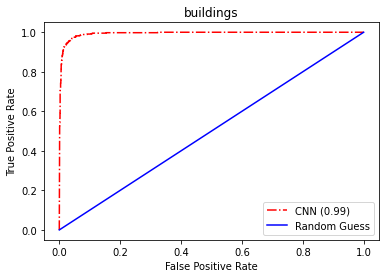

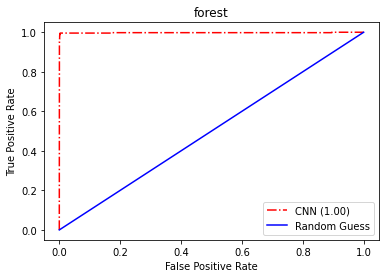

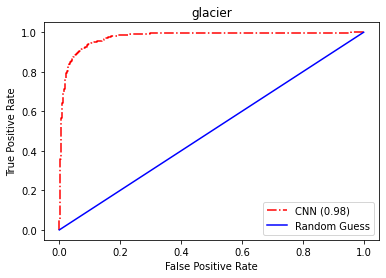

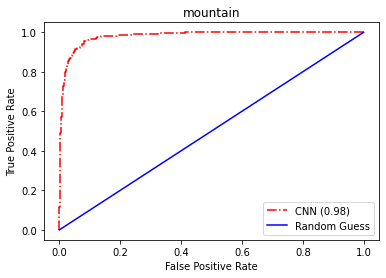

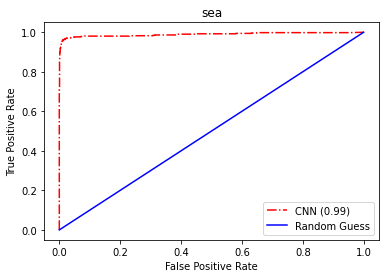

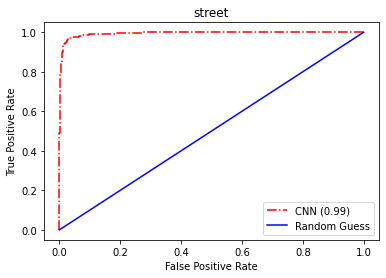

In [208]:
for clase in range(6):
    nombre_clase = num2class[clase]

    fpr, tpr, thresholds = roc_curve(y_real==clase, y_pred_proba[:,clase])
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
    ax1.set_title(nombre_clase)
    ax1.legend()
    plt.show()

In [209]:
from sklearn.metrics import plot_confusion_matrix
import itertools

In [210]:

y_pred = np.argmax(y_pred_proba, axis=1)

In [211]:
cm = confusion_matrix(y_real, y_pred, normalize='true')
cm

array([[0.95423341, 0.00228833, 0.        , 0.00228833, 0.00228833,
        0.0389016 ],
       [0.        , 0.99367089, 0.0021097 , 0.00421941, 0.        ,
        0.        ],
       [0.00361664, 0.00542495, 0.86980108, 0.07594937, 0.04520796,
        0.        ],
       [0.00571429, 0.00190476, 0.19428571, 0.7847619 , 0.01333333,
        0.        ],
       [0.01176471, 0.00196078, 0.01372549, 0.00588235, 0.96470588,
        0.00196078],
       [0.14371257, 0.00199601, 0.00399202, 0.        , 0.00199601,
        0.84830339]])

In [212]:
target_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

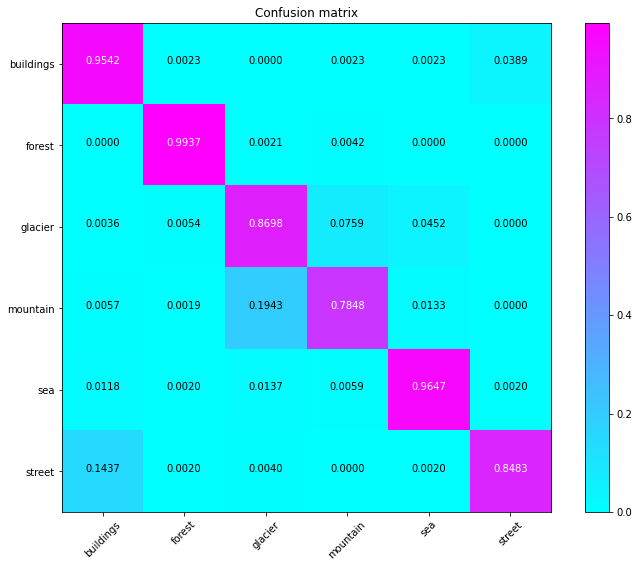

In [213]:

plt.figure(figsize=(12,9))
plt.imshow(cm, cmap='cool')
plt.colorbar()
plt.title('Confusion matrix')


tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > 0.5 else "black")


plt.show()

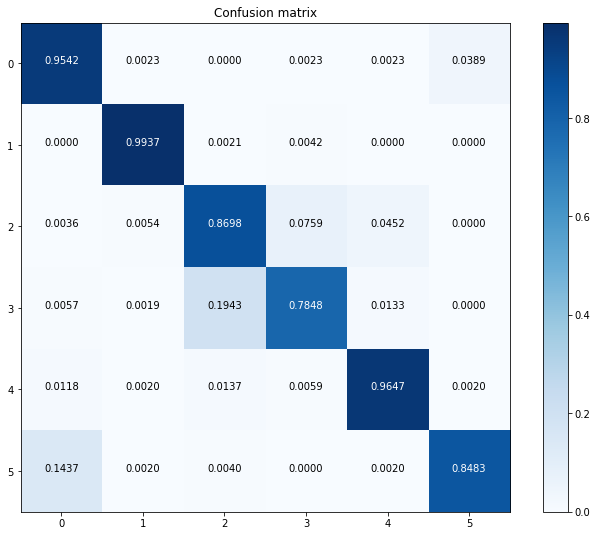

In [214]:
plt.figure(figsize=(12,9))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion matrix')

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > 0.5 else "black")


plt.show()

In [215]:
test_datagen2 = ImageDataGenerator(dtype='float32')

test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n,
    shuffle=False,
    class_mode='sparse')

Found 3000 images belonging to 6 classes.


In [216]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [217]:
test_generator2.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [218]:
y_te

array([0., 0., 0., ..., 5., 5., 5.], dtype=float32)

Clase real: glacier
buildings: 0% forest: 0% glacier: 96% mountain: 1% sea: 1% street: 0% 


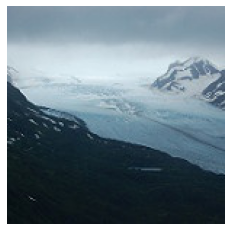

In [224]:
ind_te1 = 1001

image = X_te[ind_te1].copy()

print("Clase real:", num2class[y_te[ind_te1]])
plt.imshow(image/255, cmap='jet')
plt.axis("off")
p = model.predict(preprocess_input(np.array([image])))[0]
cadena = ""
for i in range(len(num2class)):
    cadena = cadena + "{}: {}% ".format(num2class[i], int(100*p[i]))
print(cadena)